<center><font size = "10"> Week 5 - Single Cell Electrophysiology <center>
<center><font size = "8">Home work<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 3
<br>Group member1: Laura TESTA
<br>Group member2: Alice ALBRECHT
<br>Group member3: Clara LE DRAOULEC
    
__IMPORTANT:__<font size = "3"> Exercises in <font color='red'>red</font> are mandatory assignements to be delivered by next Monday before 23:59.

In [1]:
# This will compile the mechanisms inside the MOD files (and create a new folder x86_64/special).
! nrnivmodl

/home/In silicone neurosciences/Week5/Homework
Mod files: "./NaTs2_t.mod" "./SK_E2.mod" "./SKv3_1.mod"

COBJS=''
 -> Compiling mod_func.c
x86_64-linux-gnu-gcc -O2   -I.   -I/usr/local/lib/python3.8/dist-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.so
x86_64-linux-gnu-g++ -O2 -DVERSION_INFO='8.0.0' -std=c++11 -shared -fPIC  -I /usr/local/lib/python3.8/dist-packages/neuron/.data/include -o ./libnrnmech.so -Wl,-soname,libnrnmech.so \
  ./mod_func.o ./NaTs2_t.o ./SK_E2.o ./SKv3_1.o  -L/usr/local/lib/python3.8/dist-packages/neuron/.data/lib -lnrniv -Wl,-rpath,/usr/local/lib/python3.8/dist-packages/neuron/.data/lib   
rm -f ./.libs/libnrnmech.so ; mkdir -p ./.libs ; cp ./libnrnmech.so ./.libs/libnrnmech.so
Successfully created x86_64/special


In [1]:
# Load usefull packages
%matplotlib inline

from neuron import h
import hoc
import matplotlib.pyplot as plt
import numpy as np
import math as m
import neurom as nm
import pandas as pd
from scipy.signal import find_peaks

import efel
from json2html import *
import IPython

--No graphics will be displayed.


# Optional. Stimulation protocols to study various cell properties

<font size='3'>
Your task is to design and perform two different stimulation protocols that could be used to study the AP properties (e.g. amplitude, shape, rise-time, fall-time) and passive properties (e.g. input resistance and voltage base) of the cells you have in your group folder (.asc files). When defining the cells, for the passive properties use the parameters from tutorial 01 and for the active parameters use the MOD files used in tutorial 01. Don't include any biophysics on the cell axon.

<font size='3'>Run the protocols (saving the results to a csv file - you will need those for question 3), and plot soma voltages and the current applied. Explain the motivation behind your choice of protocols - why do you think these types of protocols are usefull when studying cell behavior?
    

# <font color= 'red'>Ex1:</font>. Analysing real single cell voltage traces from patch-clamp experiments

<font size='3'>Find the voltage base, firing frequency, spike count and after-hiperpolarization depth (AHP-depth) from the recordings that you can find in your folder group (.dat files). Extract the asked features from the one or several stimulation protocols that you think you can extract the features from.

<font size='3'>You can compute it as you wish, using eFEL, scipy.signal  or creating your own functions. <font color= 'red'>[1.5 pts]

#### Traces description

* The files are named with: stimuli type (e.g. "APWaveform", "FirePattern", "IV"). 
* Sweep (repetition) number: (e.g. "APWaveform_46-51"), of increasing/decreasing amplitudes.
* Note that we have pairs of recordings with the same trace number (e.g. "exp_APWaveform_ch7_51.dat" and "exp_APWaveform_ch6_51.dat"). One of them contains the current stimulus (in this case "*ch7*") and the other the voltage response (in this case "*ch6*").
    


## First we use the FirePattern recordings

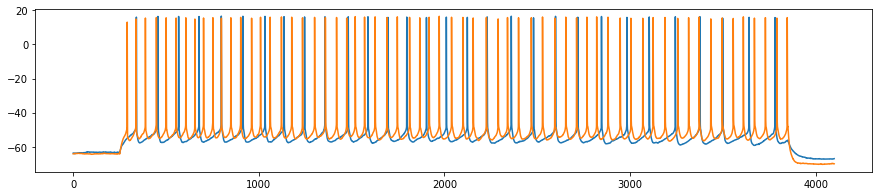

In [2]:
# Open and plot files

def get_data(fn):
    """Read  data file and formatfor plotting"""
    d = np.fromfile(fn)    
    return d[::2], d[1::2]

file_v1 = "data/exp_FirePattern_ch6_2048.dat"
file_v2 = "data/exp_FirePattern_ch6_2049.dat"


FILE_v1 = [file_v1, file_v2] 

plt.figure(figsize=(15,3))
for fv in FILE_v1:
    t, v = get_data(fv)
    plt.plot(t,v)

#### Extracting peaks, peak times and amplitude for one sweep using eFEL library

In [3]:
file_c1 = "data/exp_FirePattern_ch7_2048.dat"

t, v = get_data(file_v1)
t, i = get_data(file_c1)

# Look for start and end time
peaks_time, _ = find_peaks(i, prominence=1, height=-20)

print(np.min(peaks_time))
print(np.max(peaks_time))

3398
36411


In [4]:
stim_start = 378.9 # in ms
stim_end = 3681.0
trace = {'T': t, 'V': v, 'stim_start': [stim_start], 'stim_end': [stim_end]}

In [5]:
feature_values = efel.getFeatureValues([trace], ['voltage_base', 'Spikecount', 'mean_frequency', 'AHP_depth', 'AP_amplitude', 'peak_time', 'peak_voltage', 'min_AHP_values'])[0]
feature_values = {feature_name: list(values) for feature_name, values in feature_values.items()}
IPython.display.HTML(json2html.convert(json=feature_values))

voltage_base,-56.25837730670058
Spikecount,30
mean_frequency,8.582375478933034
AHP_depth,-1.229121930359966-1.1603734562388723-1.1416242191783255-0.9291226932994192-0.9666249821031627-0.8853719303510204-0.5416257450572317-1.2041242191783255-0.829124219157265-0.5603749820883195-0.45412040446416313-1.622871167351235-0.02912116736246162-0.4603726932294876-0.3416211672976104-0.1353757448701458-0.5916211672605627-1.4916226932397976-1.4041211672866822-0.060371167053446584-0.7541234560783394-0.6728742189167392-2.016624218894492-1.6103742187683423-1.4853704042626674-2.3416211673034155-1.5603711671714322-1.6041219300966745-2.6353719299406464-1.554122693003869
AP_amplitude,62.39999961729558563.600000379062663.1750030484180563.1187496159050262.6437492326348462.53750037403601463.368751523241162.6062488556414762.96250152308317662.9812469509116862.737501147191164.2124996203654863.8874969399860263.6812515176903163.98124884633405462.943750385951663.5000019034328562.51874733154228663.9624976945026963.7687530427921763.7124995911485664.0687522851685962.88750266421257664.1187457750085363.5437545575769662.75000191499811662.0812511151736463.66250223935893
peak_time,340.10000000000883456.30000000003525567.9000000000606677.7000000000855797.7000000001128914.10000000013931033.1000000001561135.70000000006261246.3999999999621356.2999999998621481.79999999974781587.99999999965121695.69999999955331796.99999999946111903.09999999936462010.19999999926722123.29999999916442230.2999999990672360.1999999989492479.999999998842598.5999999987322718.6999999986232846.1999999985072983.19999999838233103.4999999982733243.9999999981453376.49999999802463499.0999999979133641.39999999778373781.2999999976564
peak_voltage,16.0312499999179516.44999885547187516.4312496175342416.38750076152348416.6312503807578216.54375076139011516.47500037848125516.3124999989917416.1499996182103616.2312507593969716.22499847344281316.25625037996556415.86874961526312316.08124922513792815.80625151320842616.04374884111751615.89999961320189416.16250036910559416.57499884639130315.62499997542122216.51250074240898515.97500034608699516.40624998058593715.88125036114370716.13749881511123316.24375149179482516.30000112922309815.41250032159055315.91875070129471215.768749176415563
min_AHP_values,-57.48749923706055-57.41875076293945-57.400001525878906-57.1875-57.22500228880374-57.1437492370516-56.80000305175781-57.462501525878906-57.087501525857846-56.8187522887889-56.712497711164744-57.881248474051816-56.28749847406304-56.71874999993007-56.59999847399819-56.39375305157073-56.84999847396114-57.74999999994038-57.66249847398726-56.31874847375403-57.01250076277892-56.93125152561732-58.27500152559507-57.86875152546892-57.74374771096325-58.599998474003996-57.81874847387201-57.862499236797255-58.89374923664123-57.81249999970445


# <font color= 'red'>Ex2:</font> Combine Ex 1 and Ex 2

<font size='3'> Now let's do some electrophysiological analysis on both cells from your group folder that you have used in exercise 1. Examine your plots for the two protocols you have defined and select 2 or 3 eFeatures to help you identify differences between your two cells. Would you be able to classify the cells based on these eFeatures ? Explain your choice of features and your observations. <font color= 'red'>[2.5 pts]    
 

# 1. Get the dataframes and plots for both cells and both protocols

## Cell 1

In [6]:
# Define NEURON_1 class with specific morphology and channel behavior
class NEURON_1:
    def __init__(self):
        self.build_morphology()
        self.define_biophysics()
        
    def build_morphology(self):
        """
        Loads a 3D morphology of the neuron
        """
        # Load hoc routines to import 3D morphologies
        h.load_file('stdlib.hoc')
        h.load_file("import3d.hoc")
        #cell = h.Import3d_SWC_read() # We have a .swc morphology file
        cell = h.Import3d_Neurolucida3()

        # Read the file and creates automatically section.connect(parent) statements
        cell.input('Cell1_g3.asc')

        # Instantiate morphology for simulation and
        # execute the connect statements and loads the cell into h scope
        self.importedcell = h.Import3d_GUI(cell,0)
        self.importedcell.instantiate(None) 

        # Create python lists from the morphology with the different sections: soma, dend, apic and axon
        self.somatic = []
        self.basal = []
        self.apical = []
        #self.axonal = [] # for the moment we will forget about the axon
        self.all = []
        for sec in h.allsec():
            #print (sec)
            if 'soma' in sec.name():
                self.somatic.append(sec)
            if 'dend' in sec.name():
                self.basal.append(sec)
            if 'apic' in sec.name():
                self.apical.append(sec)
            #if 'axon' in sec.name():
            #    self.axonal.append(sec)
    
    def define_biophysics(self):
        """
        Distributes passive mechanisms and the different types
        of ion channels on the soma and dendrites
        """
        # Define passive properties
        # You can try to change the passice properties and see what happens
        for sec in h.allsec():
            sec.Ra = 100
            sec.cm = 1
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
                
        # Define active properties for soma and dendrites (basal and apical)
        for sec in self.somatic:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1
          
        for sec in self.apical:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1
        
        for sec in self.basal:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1

In [7]:
# Instantiate the cell
Cell1 = NEURON_1()


20304 lines read

Cell1_g3.asc problems


Main branch starting at line 55 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma


### Cell 1 - Protocole 1: Studying cell passive properties - subthreshold stimulation


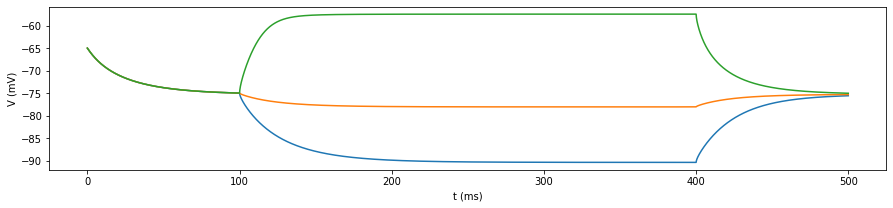

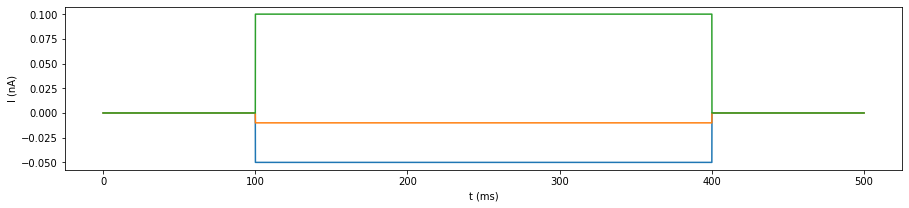

In [8]:
# Inject current steps into the soma
stim_ampl = [- 0.05, - 0.01, 0.1]

# Define plots
fig1, ax1 = plt.subplots(figsize=(15,3))
ax1.set(xlabel = 't (ms)', ylabel = 'V (mV)')

fig2, ax2 = plt.subplots(figsize=(15,3))
ax2.set(xlabel = 't (ms)', ylabel = 'I (nA)')

# Stimulation
for sa in stim_ampl:  
    # Place a stimulation electrode in the middle of the soma
    stim = h.IClamp(Cell1.somatic[0](0.5))         
    stim.delay = 100   # stim delay (ms)
    stim.dur = 300     # stim duration (ms)
    stim.amp = sa    # stim amplitude (nA)    
    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v_soma = h.Vector()
    rec_v_soma.record(Cell1.somatic[0](0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-65)
    h.continuerun(500)
    
    ax1.plot(rec_t, rec_v_soma)
    ax2.plot(rec_t, rec_i)

In [9]:
list_t = []
list_i = []
list_v = []

# Inject current steps into the soma
stim_ampl = [- 0.05, - 0.01, 0.1]

# Stimulation
for sa in stim_ampl: 
    # Place a stimulation electrode in the middle of the soma
    stim = h.IClamp(Cell1.somatic[0](0.5))         
    stim.delay = 100   # stim delay (ms)
    stim.dur = 300     # stim duration (ms)
    stim.amp = sa    # stim amplitude (nA)    
    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v_soma = h.Vector()
    rec_v_soma.record(Cell1.somatic[0](0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)
        
    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-65)
    h.continuerun(500)
    
    list_t.append(list(rec_t))
    list_i.append(list(rec_i))
    list_v.append(list(rec_v_soma))

df_Cell1 = pd.DataFrame([list_t, list_i, list_v])

### Cell 1 - Protocole 2: Studying cell active properties: suprathreshold stimulation

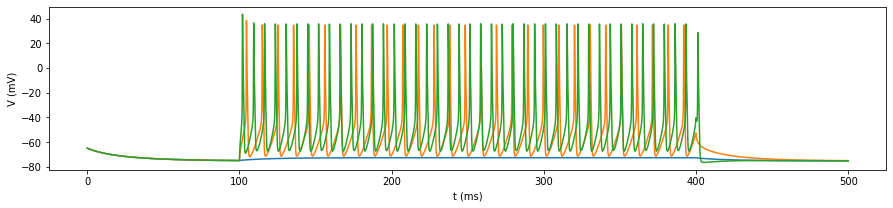

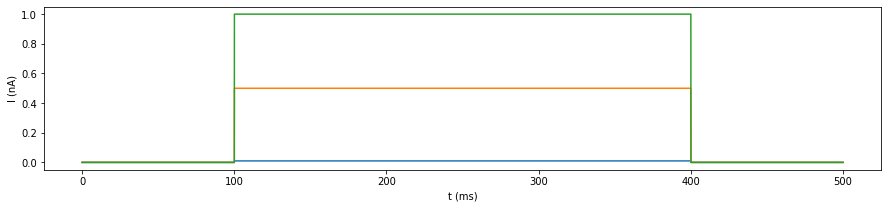

In [10]:
# Inject current steps into the soma
stim_ampl = [0.01, 0.5, 1.0]

# Define plots
fig1, ax1 = plt.subplots(figsize=(15,3))
ax1.set(xlabel = 't (ms)', ylabel = 'V (mV)')

fig2, ax2 = plt.subplots(figsize=(15,3))
ax2.set(xlabel = 't (ms)', ylabel = 'I (nA)')

# Stimulation
for sa in stim_ampl:  
    # Place a stimulation electrode in the middle of the soma
    stim = h.IClamp(Cell1.somatic[0](0.5))         
    stim.delay = 100   # stim delay (ms)
    stim.dur = 300     # stim duration (ms)
    stim.amp = sa    # stim amplitude (nA)    
    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v_soma = h.Vector()
    rec_v_soma.record(Cell1.somatic[0](0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-65)
    h.continuerun(500)
    
    ax1.plot(rec_t, rec_v_soma)
    ax2.plot(rec_t, rec_i)

## Cell 2

In [11]:
# Define NEURON_2 class with specific morphology and channel behavior

class NEURON_2:
    def __init__(self):
        self.build_morphology()
        self.define_biophysics()
        
    def build_morphology(self):
        """
        Loads a 3D morphology of the neuron
        """
        # Load hoc routines to import 3D morphologies
        h.load_file('stdlib.hoc')
        h.load_file("import3d.hoc")
        #cell = h.Import3d_SWC_read() # We have a .swc morphology file
        cell = h.Import3d_Neurolucida3()

        # Read the file and creates automatically section.connect(parent) statements
        cell.input('Cell2_g3.asc')

        # Instantiate morphology for simulation and
        # execute the connect statements and loads the cell into h scope
        self.importedcell = h.Import3d_GUI(cell,0)
        self.importedcell.instantiate(None) 

        # Create python lists from the morphology with the different sections: soma, dend, apic and axon
        self.somatic = []
        self.basal = []
        self.apical = []
        #self.axonal = [] # for the moment we will forget about the axon
        self.all = []
        for sec in h.allsec():
            #print (sec)
            if 'soma' in sec.name():
                self.somatic.append(sec)
            if 'dend' in sec.name():
                self.basal.append(sec)
            if 'apic' in sec.name():
                self.apical.append(sec)
            #if 'axon' in sec.name():
            #    self.axonal.append(sec)
    
    def define_biophysics(self):
        """
        Distributes passive mechanisms and the different types
        of ion channels on the soma and dendrites
        """
        # Define passive properties
        # You can try to change the passice properties and see what happens
        for sec in h.allsec():
            sec.Ra = 100
            sec.cm = 1
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
                
        # Define active properties for soma and dendrites (basal and apical)
        for sec in self.somatic:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1
          
        for sec in self.apical:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1
        
        for sec in self.basal:
            sec.insert('NaTs2_t')
            for seg in sec:
                seg.gNaTs2_tbar_NaTs2_t = 0.25 
            sec.insert('SK_E2')
            for seg in sec:
                seg.gSK_E2bar_SK_E2 = 0.01
            sec.insert('SKv3_1') 
            for seg in sec:
                seg.gSKv3_1bar_SKv3_1 = 0.1

In [12]:
# Instantiate the cell
Cell2 = NEURON_2()


17519 lines read


### Cell 2 - Protocole 1: Studying cell passive properties - subthreshold stimulation


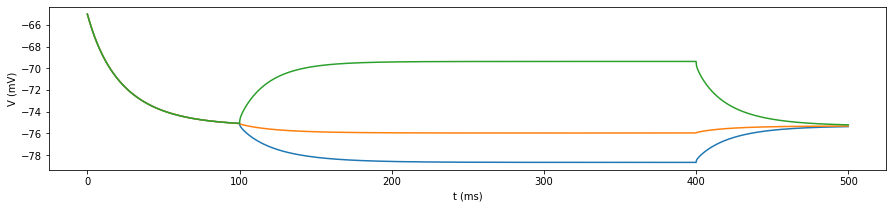

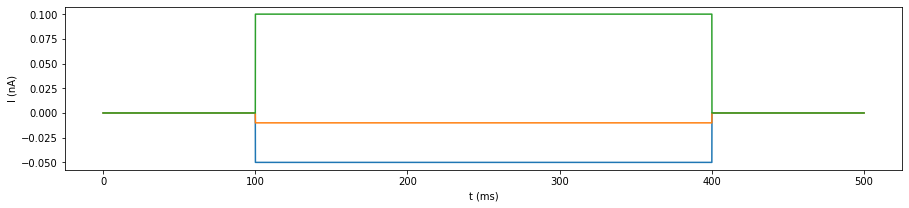

In [13]:
# Inject current steps into the soma
stim_ampl = [- 0.05, - 0.01, 0.1]

# Define plots
fig1, ax1 = plt.subplots(figsize=(15,3))
ax1.set(xlabel = 't (ms)', ylabel = 'V (mV)')

fig2, ax2 = plt.subplots(figsize=(15,3))
ax2.set(xlabel = 't (ms)', ylabel = 'I (nA)')

# Stimulation
for sa in stim_ampl:  
    # Place a stimulation electrode in the middle of the soma
    stim = h.IClamp(Cell2.somatic[0](0.5))         
    stim.delay = 100   # stim delay (ms)
    stim.dur = 300     # stim duration (ms)
    stim.amp = sa    # stim amplitude (nA)    
    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v_soma = h.Vector()
    rec_v_soma.record(Cell2.somatic[0](0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-65)
    h.continuerun(500)
    
    ax1.plot(rec_t, rec_v_soma)
    ax2.plot(rec_t, rec_i)

In [14]:
list_t = []
list_i = []
list_v = []

# Inject current steps into the soma
stim_ampl = [- 0.05, - 0.01, 0.1]

# Stimulation
for sa in stim_ampl: 
    # Place a stimulation electrode in the middle of the soma
    stim = h.IClamp(Cell2.somatic[0](0.5))         
    stim.delay = 100   # stim delay (ms)
    stim.dur = 300     # stim duration (ms)
    stim.amp = sa    # stim amplitude (nA)    
    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v_soma = h.Vector()
    rec_v_soma.record(Cell2.somatic[0](0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)
        
    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-65)
    h.continuerun(500)
    
    list_t.append(list(rec_t))
    list_i.append(list(rec_i))
    list_v.append(list(rec_v_soma))

df_Cell2 = pd.DataFrame([list_t, list_i, list_v])

### Cell 2 - Protocole 2: Studying cell active properties: suprathreshold stimulation

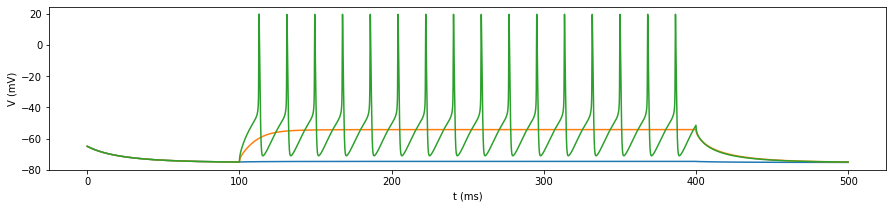

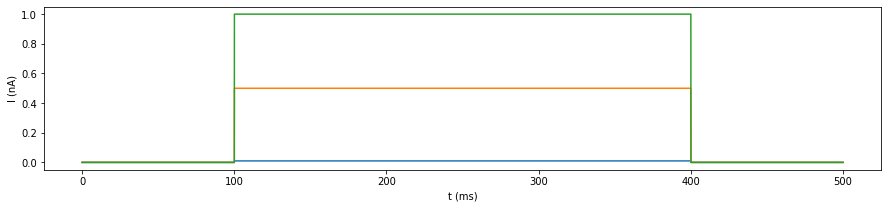

In [17]:
# Inject current steps into the soma
stim_ampl = [0.01, 0.5, 1.0]

# Define plots
fig1, ax1 = plt.subplots(figsize=(15,3))
ax1.set(xlabel = 't (ms)', ylabel = 'V (mV)')

fig2, ax2 = plt.subplots(figsize=(15,3))
ax2.set(xlabel = 't (ms)', ylabel = 'I (nA)')

# Stimulation
for sa in stim_ampl:  
    # Place a stimulation electrode in the middle of the soma
    stim = h.IClamp(Cell2.somatic[0](0.5))         
    stim.delay = 100   # stim delay (ms)
    stim.dur = 300     # stim duration (ms)
    stim.amp = sa    # stim amplitude (nA)    
    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v_soma = h.Vector()
    rec_v_soma.record(Cell2.somatic[0](0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-65)
    h.continuerun(500)
    
    ax1.plot(rec_t, rec_v_soma)
    ax2.plot(rec_t, rec_i)

# 2. Extract each trace and stock them into an array

In [ ]:
# Create one traces array per cells
traces_Cell1 = []
traces_Cell2 = []

# Define the begining and end of the stimulation
stim_start = 378.9 # in ms
stim_end = 3681.0

# Cell 1
trace1_1 = {'T': df_Cell1.loc[0,0], 'V': df_Cell1.loc[2,0], 'stim_start': [stim_start], 'stim_end': [stim_end]}
traces_Cell1.append(trace1_1)

trace1_2 = {'T': df_Cell1.loc[0,1], 'V': df_Cell1.loc[2,1], 'stim_start': [stim_start], 'stim_end': [stim_end]}
traces_Cell1.append(trace1_2)

trace1_3 = {'T': df_Cell1.loc[0,2], 'V': df_Cell1.loc[2,2], 'stim_start': [stim_start], 'stim_end': [stim_end]}
traces_Cell1.append(trace1_3)

# Cell 2
trace2_1 = {'T': df_Cell2.loc[0,0], 'V': df_Cell2.loc[2,0], 'stim_start': [stim_start], 'stim_end': [stim_end]}
traces_Cell2.append(trace2_1)

trace2_2 = {'T': df_Cell2.loc[0,1], 'V': df_Cell2.loc[2,1], 'stim_start': [stim_start], 'stim_end': [stim_end]}
traces_Cell2.append(trace2_2)

trace2_3 = {'T': df_Cell2.loc[0,2], 'V': df_Cell2.loc[2,2], 'stim_start': [stim_start], 'stim_end': [stim_end]}
traces_Cell2.append(trace2_3)

# 3. Differenciate our cells with eFeatures

For this part, I used the eFEL documentation and tried many eFeatures on our Cells. To simplify, I took only the ones with [t, V, stim_start et stim_end]  as required features, which correspond mostly to the voltage features. Some features weren't significatives in this case. For exemple,`spike_count` gave exactly the same results for the 3 traces of both cells, thus we can consider that this feature is not a great one to differenciate our cells. Below, I put the 3 features that seems to differenciate our cells the most.

In [40]:
voltage_base_Cell1 = [];
voltage_base_Cell2 = [];

voltage_deflection_Cell1 = [];
voltage_deflection_Cell2 = [];

steady_state_voltage_stimend_Cell1 = [];
steady_state_voltage_stimend_Cell2 = [];

for trace in traces_Cell1:
    feature_values = efel.getFeatureValues([trace], ['voltage_base', 'voltage_deflection', 'steady_state_voltage_stimend'])[0]
    voltage_base_Cell1.append(feature_values['voltage_base'])
    voltage_deflection_Cell1.append(feature_values['voltage_deflection'])
    steady_state_voltage_stimend_Cell1.append(feature_values['steady_state_voltage_stimend'])
    
for trace in traces_Cell2:
    feature_values = efel.getFeatureValues([trace], ['voltage_base', 'voltage_deflection', 'steady_state_voltage_stimend'])[0]
    voltage_base_Cell2.append(feature_values['voltage_base'])
    voltage_deflection_Cell2.append(feature_values['voltage_deflection'])
    steady_state_voltage_stimend_Cell2.append(feature_values['steady_state_voltage_stimend'])

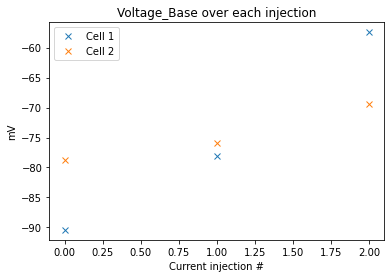

In [41]:
plt.plot(voltage_base_Cell1,'x',label="Cell 1")
plt.plot(voltage_base_Cell2,'x',label="Cell 2")
plt.legend()
plt.title("Voltage_Base over each injection")
plt.xlabel("Current injection #")
plt.ylabel("mV")
plt.show()

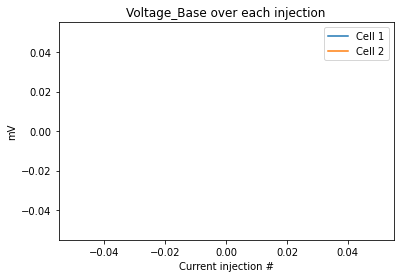

In [42]:
plt.plot(voltage_deflection_Cell1,'x',label="Cell 1")
plt.plot(voltage_deflection_Cell2,'x',label="Cell 2")
plt.legend()
plt.title("Voltage_Base over each injection")
plt.xlabel("Current injection #")
plt.ylabel("mV")
plt.show()

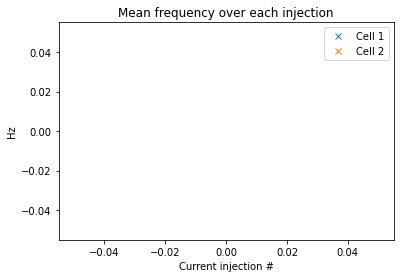

In [44]:
plt.plot(steady_state_voltage_stimend_Cell1,'x',label="Cell 1")
plt.plot(steady_state_voltage_stimend_Cell2,'x',label="Cell 2")
plt.legend()
plt.title("Mean frequency over each injection")
plt.xlabel("Current injection #")
plt.ylabel("Hz")
plt.show()

# <font color= 'red'>Ex3:</font> Genetic Algorith (Optimisation)

<font size='3'>Change the GA code in such a way that instead of the Spikecount feature, we search for a solution with AP amplitude of 96 for stim_amp = 0.5 nA and AP amplitdue of 85 for stim_amp = 0.05 nA.
    
<font size='3'>As you can see the optimisation algoithm explained in the tutorial is very simple and gives a lot of possible solutions. Explain and demonstrate how can you modify the GA optimisation to better contrain the returned solution. <font color= 'red'>[2 pts]
    

In [1]:
# Load usefull packages
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from neuron import h

# Cretae ball and stick model
# Create sections
soma = h.Section(name='soma')
dend = h.Section(name='dend')

# Topology
dend.connect(soma(1))
# Geometry
soma.L = soma.diam = 12.6157 # microns
dend.L = 200                 # microns
dend.diam = 1                # microns
h.define_shape() # Translate into 3D points.

# Biophysics
for sec in h.allsec():
    sec.Ra = 100    # Axial resistance in Ohm * cm
    sec.cm = 1      # Membrane capacitance in micro Farads / cm^2

# Insert active Hodgkin-Huxley current in the soma
# Now we won't include the values for gkbar and gnabar
soma.insert('hh')
for seg in soma:
    #seg.hh.gnabar = 0.25  # Sodium conductance in S/cm2. [0, 1]
    #seg.hh.gkbar = 0.1  # Potassium conductance in S/cm2. [0, 1]
    seg.hh.gl = 0.0003    # Leak conductance in S/cm2
    seg.hh.el = -54.3     # Reversal potential in mV

# Insert passive current in the dendrite
dend.insert('pas')
for seg in dend:
    seg.pas.g = 0.001  # Passive conductance in S/cm2
    seg.pas.e = -65    # Leak reversal potential mV

--No graphics will be displayed.


In [2]:
import efel

# Create a function of the simulation that will give us the result for the different population members
def stimulation(amp):
    stim = h.IClamp(soma(0.5))         
    stim.delay = 100   # stim delay (ms)
    stim.dur = 50     # stim duration (ms)
    stim.amp = amp    # stim amplitude (nA)    
    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v_soma = h.Vector()
    rec_v_soma.record(soma(0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-65)
    h.continuerun(200)
    
    trace = {'T': rec_t, 'V': rec_v_soma, 'stim_start': [100], 'stim_end': [200]}

    feature_values = efel.getFeatureValues([trace], ['AP_amplitude'])[0]
    if (feature_values['AP_amplitude'] is None):
        return 0
    else:
        return feature_values['AP_amplitude'][0]
    

# RUN to test
value = stimulation(0.9)
print(value)
    

92.30667257948484


First, we create a random population

In [3]:
import random
import numpy as np
import efel

def create_starting_population(gna_min, gna_max, gk_min, gk_max, pop_size):
    # Set up an initial array of all zeros
    population = np.zeros((pop_size, 2))
    for p in range(pop_size):
        gna = random.uniform(gna_min, gna_max)
        gk = random.uniform(gk_min, gk_max)
        population[p][0] = gna
        population[p][1] = gk
    return population

# RUN to test
gna_min = 0
gna_max = 1
gk_min = 0
gk_max = 1
pop_size = 10

pop = create_starting_population(gna_min, gna_max, gk_min, gk_max, pop_size)
print (pop)

[[0.76041115 0.24049456]
 [0.55004193 0.66615478]
 [0.84745854 0.32024112]
 [0.74978228 0.5975015 ]
 [0.04126642 0.04260552]
 [0.33750154 0.92686743]
 [0.54556715 0.35022796]
 [0.3915366  0.02671473]
 [0.04076068 0.96551409]
 [0.40133857 0.63530683]]


Now we compute the fitness depending on the target AP amplitude.

In [18]:
def calculate_fitness(population, goal1, stim_amp1, goal2, stim_amp2):
    scores = []
    for pop in population:
        gna = pop[0]
        gk = pop[1]
        # Introduce mechanisms in the ball and stick model
        soma.insert('hh')
        for seg in soma:
            seg.hh.gnabar = gna  # Sodium conductance in S/cm2. [0, 1]
            seg.hh.gkbar = gk  # Potassium conductance in S/cm2. [0, 1]
        fits = []
        for g, st in zip([goal1, goal2], [stim_amp1, stim_amp2]):
            value = stimulation(st)
            fit = np.abs(g - int(value))
            fits.append(fit)
        scores.append(np.mean(fits))
    return scores



In [5]:
def select_individual_by_tournament(population, scores):
    # Get population size
    population_size = len(scores)
    
    # Pick individuals for tournament
    fighter_1 = random.randint(0, population_size-1)
    fighter_2 = random.randint(0, population_size-1)
    
    # Get fitness score for each
    fighter_1_fitness = scores[fighter_1]
    fighter_2_fitness = scores[fighter_2]
    
    # Identify individual with smallest fitness
    # Fighter 1 will win if score are equal
    if fighter_1_fitness <= fighter_2_fitness:
        winner = fighter_1
    else:
        winner = fighter_2
    
    # Return winner
    return population[winner, :]

# RUN to test
parent1 = select_individual_by_tournament(pop, fit_scor)
parent2 = select_individual_by_tournament(pop, fit_scor)
parent3 = select_individual_by_tournament(pop, fit_scor)
parent4 = select_individual_by_tournament(pop, fit_scor)
parent5 = select_individual_by_tournament(pop, fit_scor)
parent6 = select_individual_by_tournament(pop, fit_scor)
print(parent1)
print(parent2)
print(parent3)
print(parent4)
print(parent5)
print(parent6)

[0.76041115 0.24049456]
[0.76041115 0.24049456]
[0.76041115 0.24049456]
[0.76041115 0.24049456]
[0.84745854 0.32024112]
[0.40133857 0.63530683]


In [6]:
def breed_by_crossover(parent_1, parent_2):
    # Create children. np.hstack joins two arrays
    child_1 = np.hstack((parent_1[0],parent_2[1]))  
    child_2 = np.hstack((parent_1[1],parent_2[0]))    
    # Return children
    return child_1, child_2

child1, child2 = breed_by_crossover(parent1, parent2)
child3, child4 = breed_by_crossover(parent3, parent4)
child5, child6 = breed_by_crossover(parent5, parent6)

print (child1)
print (child2)
print (child3)
print (child4)
print (child5)
print (child6)

[0.76041115 0.24049456]
[0.24049456 0.76041115]
[0.76041115 0.24049456]
[0.24049456 0.76041115]
[0.84745854 0.63530683]
[0.32024112 0.40133857]


In [7]:
def randomly_mutate_population(population, mutation_probability):  
    for p in population:
        filt = random.random()
        if filt < mutation_probability:
            # Apply random mutation
            gna = random.uniform(0, 1)
            p[0] = gna
            gk = random.uniform(0, 1)
            p[1] = gk
        else:
            pass
    # Return mutation population
    return population

#RUN to test
new_pop = np.stack((child1, child2))
print (new_pop)

mut_pop = randomly_mutate_population(new_pop, 0.25)
print (mut_pop)


[[0.76041115 0.24049456]
 [0.24049456 0.76041115]]
[[0.76041115 0.24049456]
 [0.24049456 0.76041115]]


Starting best score: 8.5 (gna = 0.59, gk = 0.63)
Starting best score: 8.5 (gna = 0.67, gk = 0.75)
Starting best score: 8.5 (gna = 0.47, gk = 0.32)
Starting best score: 8.5 (gna = 0.93, gk = 0.97)
Starting best score: 8.5 (gna = 0.70, gk = 0.56)
Starting best score: 8.5 (gna = 0.69, gk = 0.83)
Starting best score: 8.5 (gna = 0.40, gk = 0.23)
Generation 0 best score: 8.5 (gna = 0.46, gk = 0.59)
Generation 0 best score: 8.5 (gna = 0.52, gk = 0.47)
Generation 0 best score: 8.5 (gna = 0.52, gk = 0.53)
Generation 0 best score: 8.5 (gna = 0.93, gk = 0.98)
Generation 0 best score: 8.5 (gna = 0.40, gk = 0.56)
Generation 0 best score: 8.5 (gna = 0.47, gk = 0.52)
Generation 1 best score: 8.5 (gna = 0.63, gk = 0.59)
Generation 1 best score: 8.5 (gna = 0.47, gk = 0.46)
Generation 1 best score: 8.5 (gna = 0.52, gk = 0.59)
Generation 1 best score: 8.5 (gna = 0.47, gk = 0.46)
Generation 1 best score: 8.5 (gna = 0.47, gk = 0.47)
Generation 1 best score: 8.5 (gna = 0.52, gk = 0.52)
Generation 1 best sco

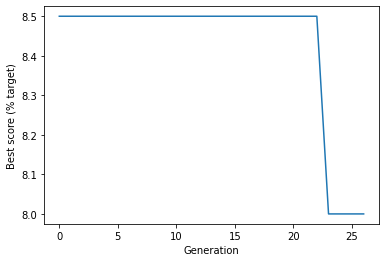

In [13]:
# Set general parameters
population_size = 20
maximum_generation = 5
best_score_progress = [] # Tracks progress
gna_min = 0.0
gna_max = 1.0
gk_min = 0.0
gk_max = 1.0
stim_amp2 = 0.5 # nA
goal2 = 96 # 
stim_amp2 = 0.05 # nA
goal2 = 85 # 
# Create starting population
# RUN
population = create_starting_population(gna_min, gna_max, gk_min, gk_max, population_size)

# Display best score in starting population
fit_scores = calculate_fitness(population, goal1, stim_amp1, goal2, stim_amp2)
best_score = np.min(fit_scores)

for i in range(len(fit_scores)):
    if fit_scores[i] == best_score:
        gna = population[i][0]
        gk = population[i][1]
        print ('Starting best score: %.1f (gna = %.2f, gk = %.2f)' %(best_score, gna, gk))
        best_score_progress.append(best_score)
    
# Now we'll go through the generations of genetic algorithm
for generation in range(maximum_generation):
    # Create an empty list for new population
    new_population = []
    
    # Create new popualtion generating two children at a time
    for i in range(int(population_size/2)):
        parent_1 = select_individual_by_tournament(population, fit_scores)
        parent_2 = select_individual_by_tournament(population, fit_scores)
        child_1, child_2 = breed_by_crossover(parent_1, parent_2)
        new_population.append(child_1)
        new_population.append(child_2)
    
    # Replace the old population with the new one
    population = np.array(new_population)
    
    # Apply mutation
    mutation_rate = 0.0020
    population = randomly_mutate_population(population, mutation_rate)

    # Score best solution, and add to tracker
    pop_scores = calculate_fitness(population, goal1, stim_amp1, goal2, stim_amp2)
    best_score = np.min(pop_scores)
    
    for i in range(len(pop_scores)):
        if pop_scores[i] == best_score:
            gna = population[i][0]
            gk = population[i][1]
            print ('Generation %s best score: %.1f (gna = %.2f, gk = %.2f)' %(generation, best_score, gna, gk))
            best_score_progress.append(best_score)
        
# GA has completed required generation

# Plot progress
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(best_score_progress)
plt.xlabel('Generation')
plt.ylabel('Best score (% target)')
plt.show()

According to our results, we would chose a gna of 0.56 and gk of 0.97 for our model, as it is the min of the "error". However, note that a lot of different possibilities exist for the conductance leading to a similar AP amplitude. This proves that the GA is simple and can be optimized to narrow the possibilities. 

An important aspect if we want to optimize the parameter according to a given AP amplitude is that depending on the current that is injected in the cell, there will not always be an AP. For example, with a simtulation amplitude of 0.05nA, there are only very few APs that are induced. This is taken care of in the 'stimulation' function: the AP amplitude is 0 if there are no APs induced by the stimulation. 

This might explain the bad score that we get at the end: it is hard to get an AP amplitude of 85 when most AP are not present. 

Now, let's observe the cell behavior with the optimal fetures (gk and gna)


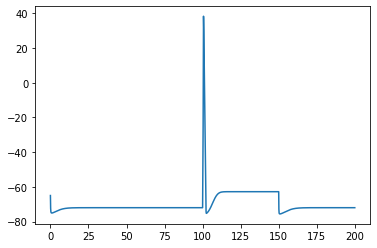

In [17]:
soma.insert('hh')
for seg in soma:
    seg.hh.gnabar = 0.56  # Sodium conductance in S/cm2. [0, 1]
    seg.hh.gkbar = 0.97 # Potassium conductance in S/cm2. [0, 1]


stim = h.IClamp(soma(0.5))         
stim.delay = 100   # stim delay (ms)
stim.dur = 50     # stim duration (ms)
stim.amp = 0.5    # stim amplitude (nA)    
# Initialize NEURON vectors to record time, voltage and current
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)
# membrame potential vector
rec_v_soma = h.Vector()
rec_v_soma.record(soma(0.5)._ref_v)
# current
rec_i = h.Vector()
rec_i.record(stim._ref_i)
# Initialize and run a simulation
h.load_file('stdrun.hoc')
h.finitialize(-65)
h.continuerun(200)


fig=plt.figure()
plt.plot(rec_t, rec_v_soma)
plt.show()

We indeed get an amplitude that is close to the solution (96 for a stimulation of 0.5nA) but not exactly equal.

To better constraint the solution, we could add other goals to use to optimize the parameters. Indeed, many different combinaiton of gna and gk lead to similar AP amplitude. Therefore, it is hard to use only thisparameter to optimize the conductance. We could for example try to constrain the cell using the spikecount, so that it spikes only a specific number of time. Additionally, we could try to set the time to hyperpolarize as another goal. By adding more constraints, we should narrow the number of solutions for the conductances. 